In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import *
from utils.constants import *
from src.shap import *



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yinpuli/opt/anaconda3/envs/py-311/lib/python3.11/site-p

In [2]:
######## Import data ########


y_train = pd.read_csv(get_absolute_path('y_train.csv', 'data'))
y_test = pd.read_csv(get_absolute_path('y_test.csv', 'data'))


stack_train = pd.read_csv(get_absolute_path('stacked_X_tr.csv', 'data'))
stack_test  = pd.read_csv(get_absolute_path('stacked_X_te.csv', 'data'))

stack_train = stack_train.astype(column_data_extended_types)
stack_test = stack_test.astype(column_data_extended_types)



######## Feature Engineering ##########

# Select numeric and categorical columns
numeric_columns = stack_train.select_dtypes(include=['float64']).columns
categorical_columns = [#'Date', 
                       'Location_ID',
                    #    'Year',
                       'Month',
                       'Week',
                       'Weekday',
                       'Season'
                       ]  # Add any categorical columns here

# Create preprocessing transformers
numeric_transformer = StandardScaler()  # we can use other scalers as well
categorical_transformer = OneHotEncoder(drop=None)  # Use one-hot encoding for categorical columns

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Fit the preprocessor on training data and transform both train and test data
X_train_preprocessed = preprocessor.fit_transform(stack_train)
X_test_preprocessed  = preprocessor.transform(stack_test)


# Get the column names after one-hot encoding
categorical_encoded_columns = preprocessor.named_transformers_['cat']\
                                    .get_feature_names_out(input_features=categorical_columns)

# Convert X_train_preprocessed and X_test_preprocessed to DataFrames

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed.toarray(), columns=np.concatenate([numeric_columns, categorical_encoded_columns]))
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed.toarray(), columns=np.concatenate([numeric_columns, categorical_encoded_columns]))

Xgb Model File Paths: ['/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/best_xgb_model.joblib', '/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/shap_on_test/best_xgb_shap_bar.png', '/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/shap_on_test/best_xgb_shap_val.png']
Tree Based Model...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


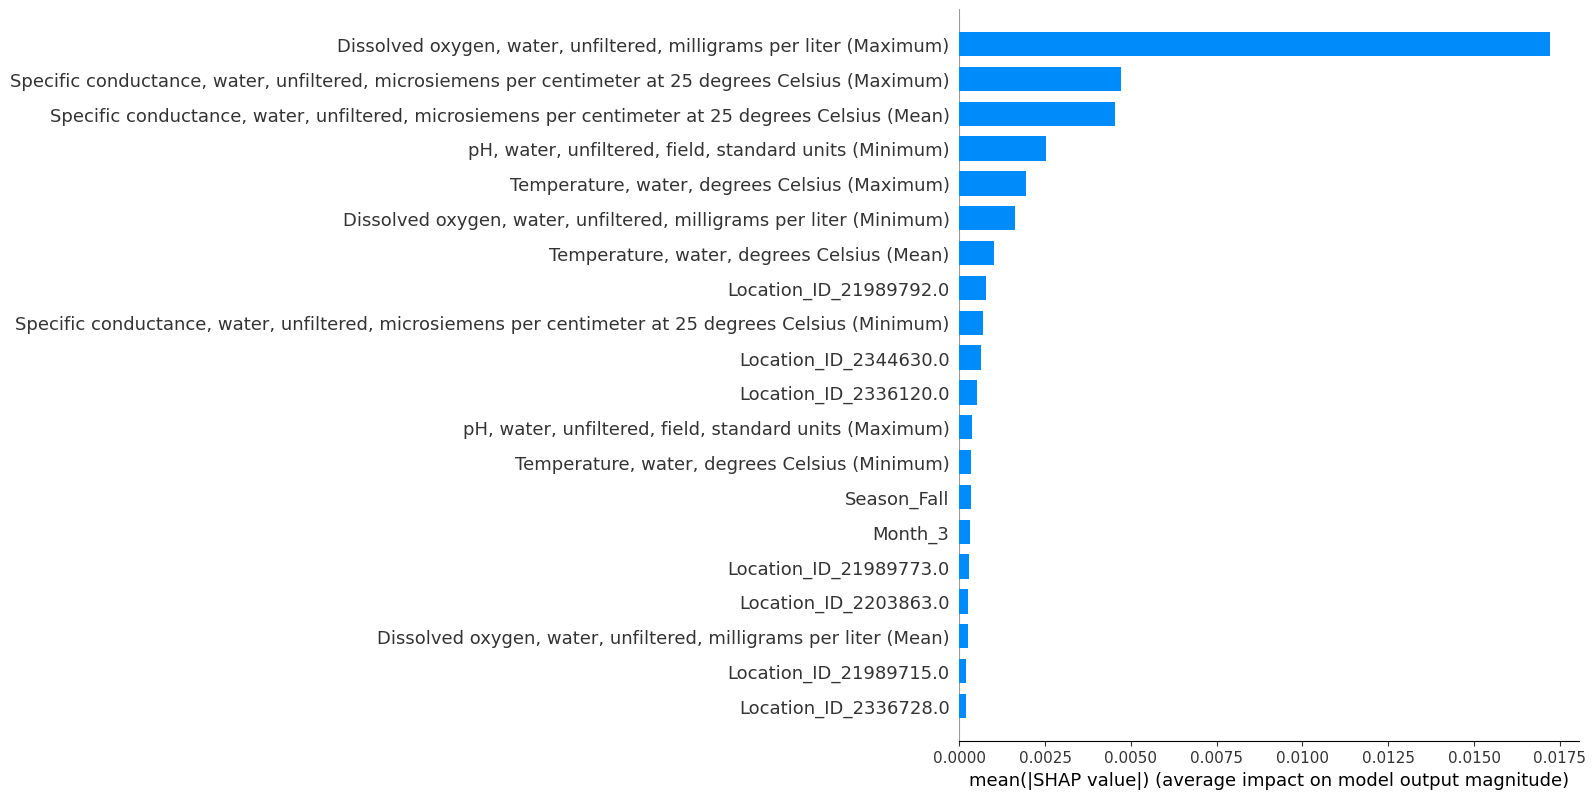

<Figure size 1500x1000 with 0 Axes>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


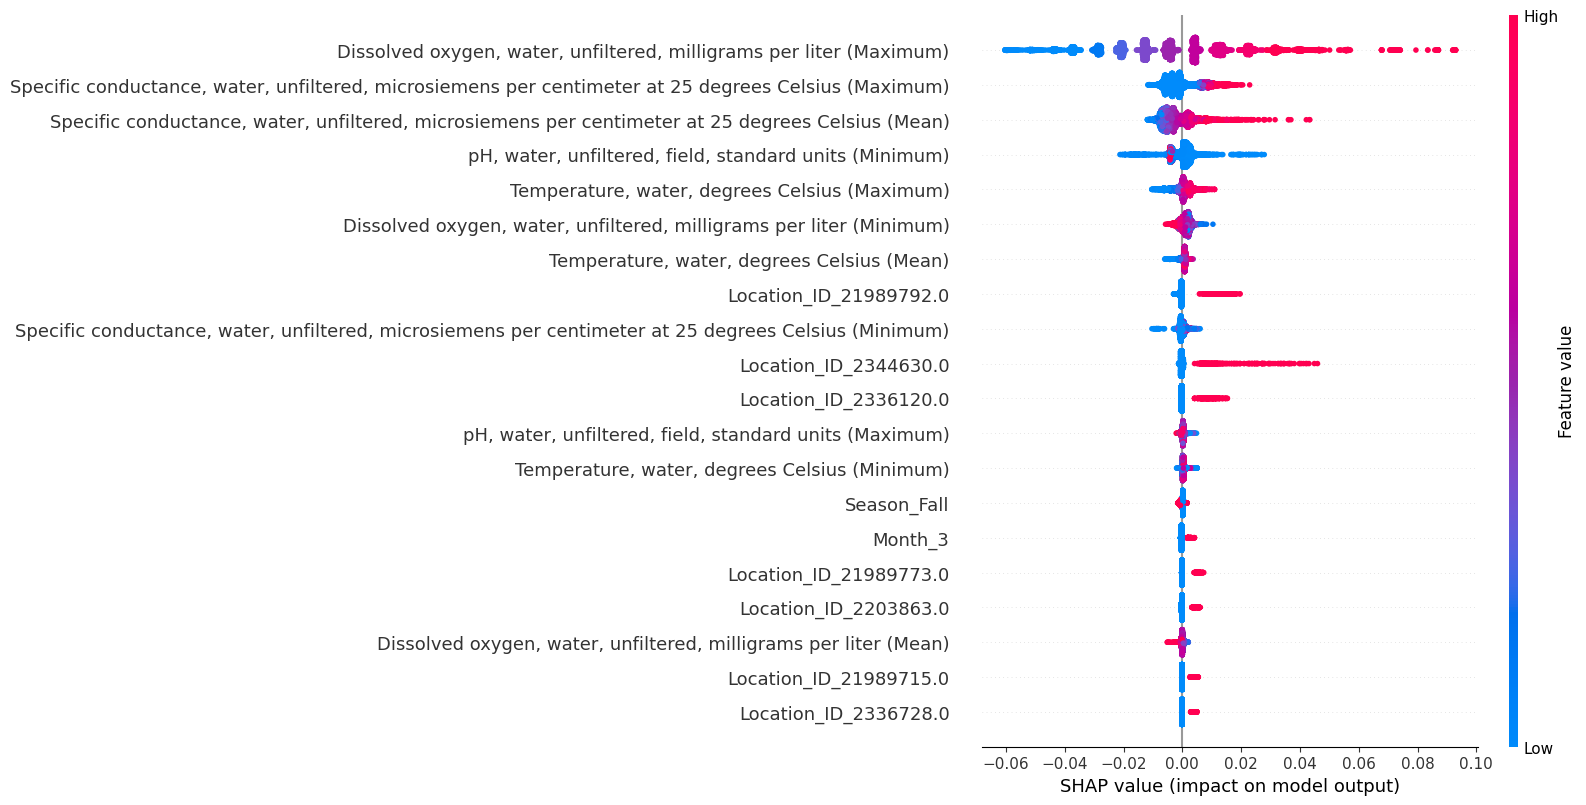

<Figure size 1500x1000 with 0 Axes>

Rf Model File Paths: ['/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/best_rf_model.joblib', '/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/shap_on_test/best_rf_shap_bar.png', '/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/shap_on_test/best_rf_shap_val.png']
Tree Based Model...


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


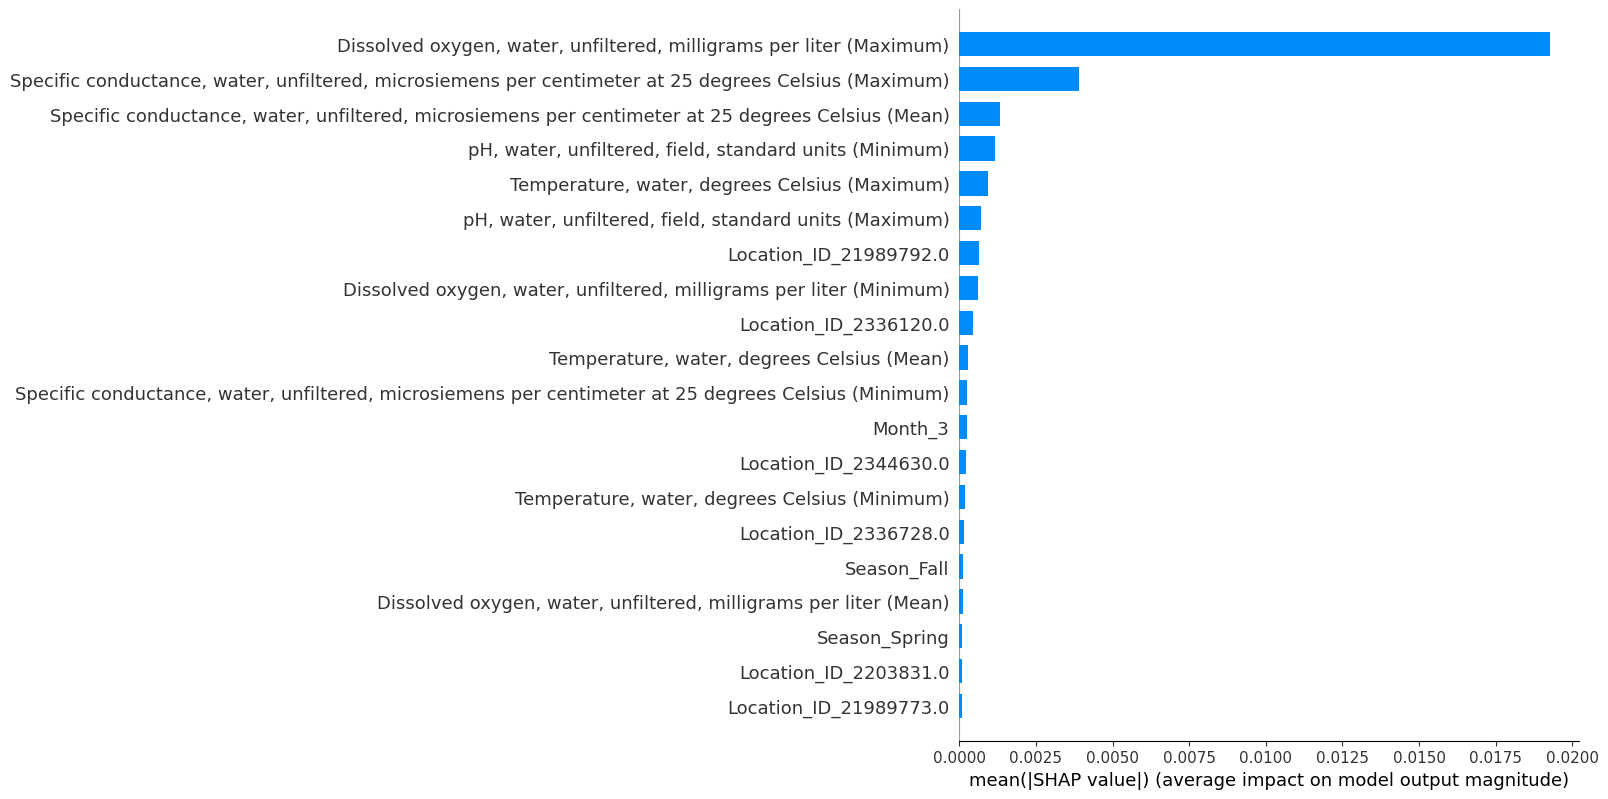

<Figure size 1500x1000 with 0 Axes>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


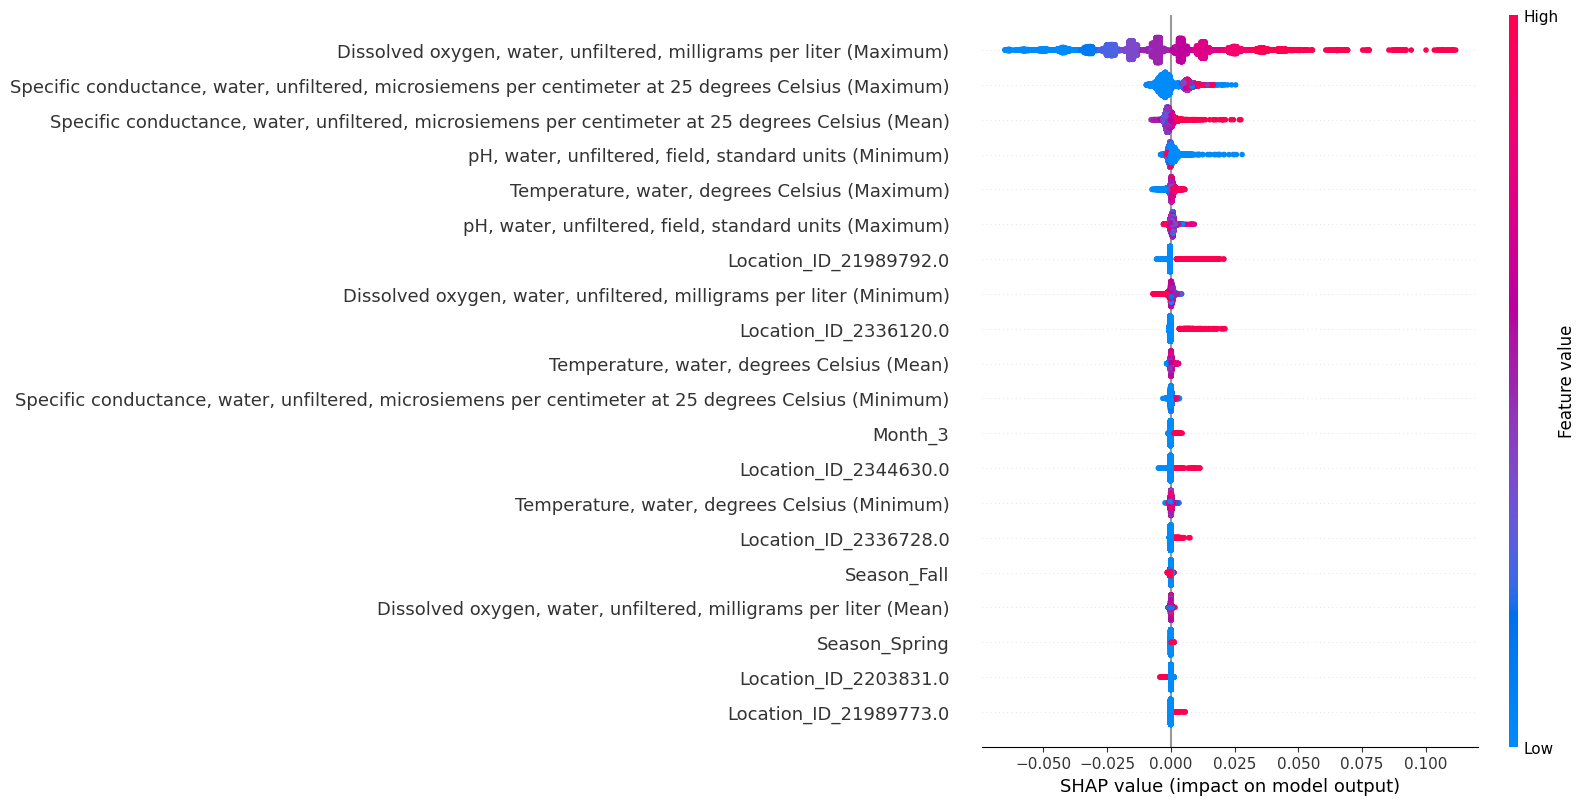

<Figure size 1500x1000 with 0 Axes>

Mlp Model File Paths: ['/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/best_mlp_model.joblib', '/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/shap_on_test/best_mlp_shap_bar.png', '/Users/yinpuli/Documents/python-projects/water-quality-prediction/results/shap_on_test/best_mlp_shap_val.png']
MLP Model...


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Provided model function fails when applied to the provided data set.


TypeError: 'MLPRegressor' object is not callable

In [3]:
########### Generate SHAP results on test set


# List of model names
model_names = ['xgb', 'rf' , 'mlp', 'lin'
]

# Relative path
rel_path = 'results' 

# # Dictionary to store file paths for each model
# model_file_paths = {}

# Loop through each model name
for model_name in model_names:
    file_paths = generate_file_paths_for_shap_2(model_name, rel_path)
    # model_file_paths[model_name] = file_paths
    print(f"{model_name.capitalize()} Model File Paths:", file_paths)

    gen_shap_results(
        load_file_path = file_paths[0]
        , save_file_path_1 = file_paths[1]
        , save_file_path_2 = file_paths[2]
        , refit_X = X_test_preprocessed_df
        , refit_y = y_test
        , figure_dpi = 300
    )


